In [13]:
import snapatac2 as snap
import scanpy as sc
import os
import pandas as pd
import numpy as np
from scipy import stats as ss
import pickle

import pycisTopic
from pycisTopic.cistopic_class import create_cistopic_object

### openBLAS will not work properly in jupyter notebook
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

## Input RNA: read h5ad and select cells to process

In [2]:
### use the same object for integration
### Change name to atac barcode so that all aligned
mmg = sc.read_h5ad("MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.subset.h5ad")
validc = np.array(mmg.obs.dna + ":" + mmg.obs.atac_bc)

In [82]:
### rename to keep consistent with cistopic file
mmg.obs['final_rna_bc'] = mmg.obs_names
mmg.obs.index = np.array(mmg.obs.dna + ":" + mmg.obs.atac_bc)
mmg.obs_names = mmg.obs.index
mmg

AnnData object with n_obs × n_vars = 116373 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score', 'doublet_ident', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'region.color', 'region.name', 'structure.color', 'label', 'prob', 'RNA_snn_res.0.5', 'seurat_clusters', 'filter', 'cluster', 'subcluster', 'supercluster_name', 'supercluster_bootstrapping_probability', 'cluster_name', 'cluster_bootstrapping_probability', 'subcluster_name', 'subcluster_bootstrapping_probability', 'subclass', 'subclass_corrected', 'keep', 'cluster_manual_name', 'cluster_manual', 'supercluster_manual', 'class', 'final_rna_bc'
    var: 'vf_vst_counts.1_mean', 'vf_vst_counts.1_variance', 'vf_vst_counts.1_variance.expected', 'vf_vst_counts.1_variance.standardized', 'vf_vst_counts.1_variable', 'vf_vst_counts.1_rank', 'vf_vst_counts.2_mean', 'vf_vst_counts.2_variance', 'vf_vst_counts.2_variance.expected', 'vf_vst_counts.2_vari

In [85]:
mmg.write_h5ad("MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.subset.rename.h5ad")

... storing 'orig.ident' as categorical
... storing 'doublet_ident' as categorical
... storing 'dna' as categorical
... storing 'rna' as categorical
... storing 'region' as categorical
... storing 'structure' as categorical
... storing 'donor' as categorical
... storing 'target' as categorical
... storing 'rna_bc' as categorical
... storing 'atac_bc' as categorical
... storing 'index' as categorical
... storing 'region.color' as categorical
... storing 'region.name' as categorical
... storing 'structure.color' as categorical
... storing 'label' as categorical
... storing 'cluster' as categorical
... storing 'subcluster' as categorical
... storing 'supercluster_name' as categorical
... storing 'cluster_name' as categorical
... storing 'subcluster_name' as categorical
... storing 'subclass' as categorical
... storing 'subclass_corrected' as categorical
... storing 'cluster_manual_name' as categorical
... storing 'cluster_manual' as categorical
... storing 'supercluster_manual' as categor

## Input H3K27ac: read h5ad and select cells to process

In [3]:
### fetch same barocdes as RNA
K27ac = snap.read("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_240601.h5ad", backed=None)
K27ac = K27ac[validc,:]
K27ac

View of AnnData object with n_obs × n_vars = 116373 × 544735
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score_y', 'doublet_ident', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'condition', 'leiden', 'subclass', 'subclass_corrected', 'supercluster_manual', 'cluster_manual_name'
    uns: 'AnnDataSet'

### snapatac2 to cistopic

In [75]:
mtx = pd.DataFrame(K27ac.X.T.toarray())
mtx.index = K27ac.var_names
mtx.columns = K27ac.obs_names
obj = create_cistopic_object(fragment_matrix=mtx, tag_cells = False)
obj.add_cell_data(K27ac.obs)
print(obj)

2025-09-06 20:19:10 - INFO - Converting fragment matrix to sparse matrix
2025-09-06 20:29:06 - INFO - Creating CistopicObject
2025-09-06 20:29:11 - INFO - Done!


CistopicObject from project cisTopic with n_cells × n_regions = 116373 × 543435


In [ ]:
os.environ['MALLET_MEMORY'] = '400G'
from pycisTopic.lda_models import run_cgs_models_mallet
mallet_path="/home/y2xie/packages/Mallet-202108/bin/mallet"

# Run models
models=run_cgs_models_mallet(
    obj,
    n_topics=[30, 35, 40, 50, 60, 75],
    n_cpu=24,
    n_iter=500,
    random_state=921,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path="cistopic",
    save_path="cistopic",
    mallet_path=mallet_path,
)

2025-09-06 20:29:11 - INFO - Formatting input to corpus
2025-09-06 20:29:12 - INFO - Running model with 30 topics
2025-09-06 20:29:12 - INFO - Serializing temporary corpus to cistopic/corpus.txt
2025-09-06 20:29:38 - INFO - Converting temporary corpus to MALLET format with: /home/y2xie/packages/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input cistopic/corpus.txt --output cistopic/corpus.mallet
2025-09-06 20:30:19 - INFO - Training MALLET LDA with: /home/y2xie/packages/Mallet-202108/bin/mallet train-topics --input cistopic/corpus.mallet --num-topics 30 --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state cistopic/3ff964_state.mallet.gz --output-doc-topics cistopic/3ff964_doctopics.txt --output-topic-keys cistopic/3ff964_topickeys.txt --num-iterations 500 --inferencer-filename cistopic/3ff964_inferencer.mallet --doc-topics-threshold 0.0 --random-seed 921
2025-09-06 21:07:19 - INFO - loading assigned topics from cistopic

In [ ]:
outDir = "cistopic/"
with open(outDir + 'Mallet_models_500.pkl', 'wb') as f:
    pickle.dump(models, f)

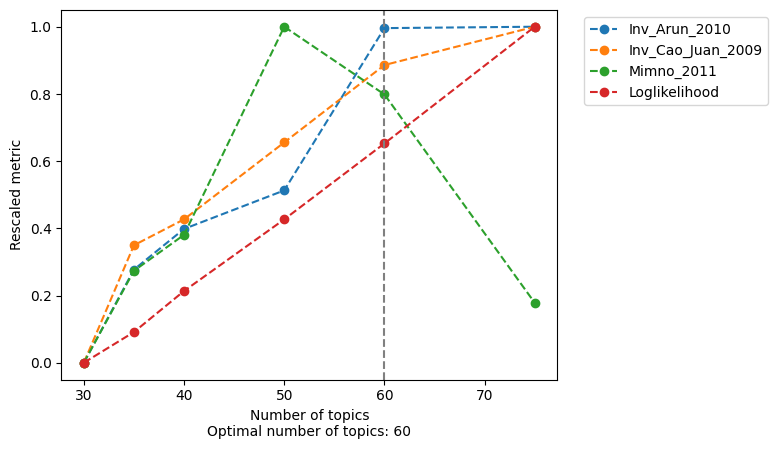

2025-09-07 07:10:46 - INFO - maxp pruned
2025-09-07 07:10:46 - INFO - cmap pruned
2025-09-07 07:10:46 - INFO - kern dropped
2025-09-07 07:10:46 - INFO - post pruned
2025-09-07 07:10:46 - INFO - FFTM dropped
2025-09-07 07:10:46 - INFO - GPOS pruned
2025-09-07 07:10:46 - INFO - GSUB pruned
2025-09-07 07:10:46 - INFO - glyf pruned
2025-09-07 07:10:46 - INFO - Added gid0 to subset
2025-09-07 07:10:46 - INFO - Added first four glyphs to subset
2025-09-07 07:10:46 - INFO - Closing glyph list over 'GSUB': 46 glyphs before
2025-09-07 07:10:46 - INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'I', 'J', 'L', 'M', 'N', 'O', 'R', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'zero']
2025-09-07 07:10:46 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 36, 38, 44, 45, 47, 48, 49

In [86]:
from pycisTopic.lda_models import evaluate_models
model=evaluate_models(models,
                     select_model=60, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'model_selection.pdf')

In [97]:
obj.add_LDA_model(model)
with open(outDir + 'MiniAtlas_H3K27ac_snATAC_whole.union.peaks_240601_cisTopicObject.subset.pkl', 'wb') as f:
    pickle.dump(obj, f)

In [2]:
outDir = "cistopic/"
with open(outDir + 'MiniAtlas_H3K27ac_snATAC_whole.union.peaks_240601_cisTopicObject.subset.pkl', 'rb') as f:
    obj = pickle.load(f)

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-07 10:56:33,719	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-09-07 10:56:33 - INFO - cffi mode is CFFI_MODE.ANY
2025-09-07 10:56:33 - INFO - R home found: /home/y2xie/miniconda3/envs/seurat/lib/R
2025-09-07 10:56:35 - INFO - R library path: 
2025-09-07 10:56:35 - INFO - LD_LIBRARY_PATH: 
2025-09-07 10:56:35 - INFO - Default options to initialize R: rpy2, --quiet, --no-save
2025-09-07 10:56:35 - INFO - R is already initialized. No need to initialize.


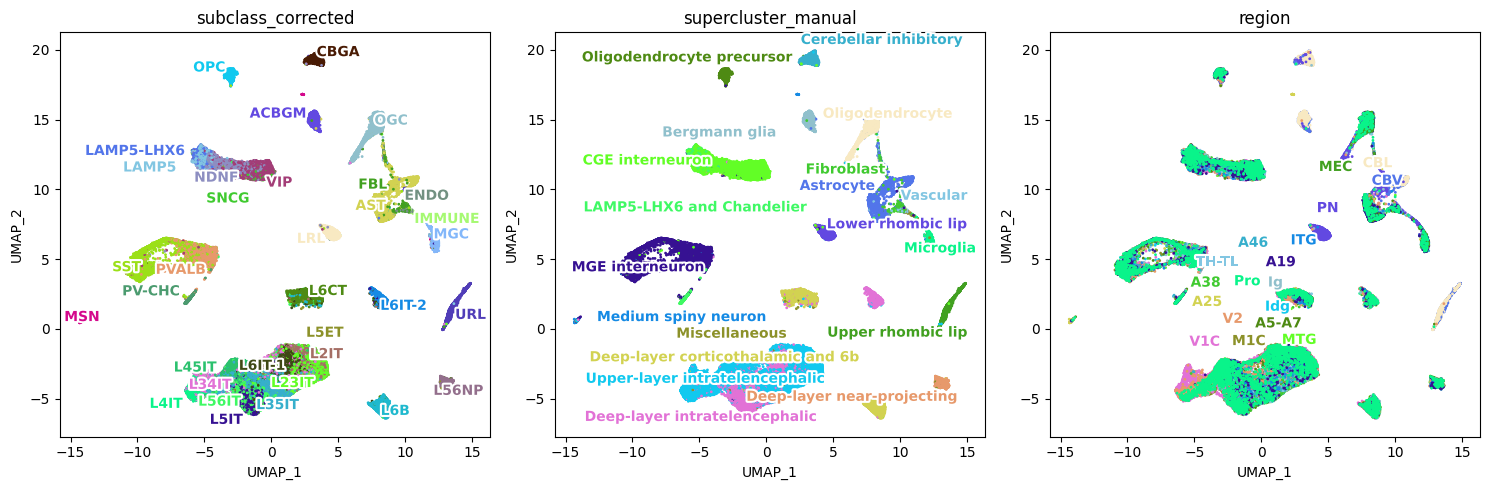

In [81]:
from pycisTopic.clust_vis import *
run_umap(obj, target = 'cell', scale=True)
plot_metadata(obj,
              reduction_name='UMAP',
              variables=['subclass_corrected', 'supercluster_manual', 'region'], # Labels from RNA and new clusters
              target='cell', num_columns=3,
              text_size=10,
              dot_size=1,
              figsize=(15,5))

In [3]:
from pycisTopic.topic_binarization import binarize_topics
region_bin_topics_otsu = binarize_topics(
    obj, method='otsu',
    plot=False, num_columns=5
)

In [4]:
region_bin_topics_top_3k = binarize_topics(
    obj, method='ntop', ntop = 3_000,
    plot=False, num_columns=5
)

In [5]:
binarized_cell_topic = binarize_topics(
    obj,
    target='cell',
    method='li',
    plot=False,
    num_columns=5, nbins=100)

In [103]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
topic_annot = topic_annotation(
    obj,
    annot_var='subclass_corrected',
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr = 0.2
)

topic_annot

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


,subclass_corrected,Ratio_cells_in_topic,Ratio_group_in_population,is_general
Topic1,"L35IT, L4IT, L34IT, L56IT, L45IT",0.059301,0.202143,False
Topic2,"FBL, AST, ACBGM, OGC, OPC, IMMUNE, MGC, ENDO, ...",0.101484,0.184055,False
Topic3,"FBL, AST, ACBGM, OGC, PVALB, OPC, L6IT-2, IMMU...",0.184699,0.352676,False
Topic4,"FBL, AST, ACBGM, ENDO",0.062738,0.064886,False
Topic5,"FBL, AST, ACBGM",0.027635,0.062729,False
Topic6,"L23IT, L5ET, L35IT, L6IT-2, L34IT, L5IT, L2IT,...",0.155637,0.270716,False
Topic7,"L23IT, L4IT, LRL, L34IT",0.0262,0.131362,False
Topic8,"FBL, L6CT, AST, ACBGM, OGC, PVALB, L4IT, L6IT-...",0.238337,0.337209,False
Topic9,"L35IT, L5IT, L56IT, L45IT, L6IT-1",0.090811,0.198766,False
Topic10,"L6CT, L6B",0.038738,0.076281,False


### Output regions set

In [6]:
os.makedirs(os.path.join(outDir, "region_sets"), exist_ok = True)
os.makedirs(os.path.join(outDir, "region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join(outDir, "region_sets", "Topics_top_3k"), exist_ok = True)
# os.makedirs(os.path.join(outDir, "region_sets", "DARs_cell_type"), exist_ok = True)

In [10]:
out_dir = "scplus_pipeline/"

from pycisTopic.utils import region_names_to_coordinates
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_set", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [11]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_set", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

Also export the DAR as region set

## Process H3K27me3 for GRN analysis

In [7]:
mmg = sc.read_h5ad("MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.subset.H3K27me3.h5ad")
validc = np.array(mmg.obs.dna + ":" + mmg.obs.atac_bc)

### rename to keep consistent with cistopic file
mmg.obs['final_rna_bc'] = mmg.obs_names
mmg.obs.index = np.array(mmg.obs.dna + ":" + mmg.obs.atac_bc)
mmg.obs_names = mmg.obs.index
mmg

AnnData object with n_obs × n_vars = 111343 × 5572
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score', 'doublet_ident', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'region.color', 'region.name', 'structure.color', 'label', 'prob', 'RNA_snn_res.0.5', 'seurat_clusters', 'filter', 'cluster', 'subcluster', 'supercluster_name', 'supercluster_bootstrapping_probability', 'cluster_name', 'cluster_bootstrapping_probability', 'subcluster_name', 'subcluster_bootstrapping_probability', 'subclass', 'subclass_corrected', 'keep', 'cluster_manual_name', 'cluster_manual', 'supercluster_manual', 'class', 'nCount_DORC_ac', 'nFeature_DORC_ac', 'nCount_DORC_me3', 'nFeature_DORC_me3', 'final_rna_bc'
    var: 'vf_vst_counts.1_mean', 'vf_vst_counts.1_variance', 'vf_vst_counts.1_variance.expected', 'vf_vst_counts.1_variance.standardized', 'vf_vst_counts.1_variable', 'vf_vst_counts.1_rank', 'vf_vst_counts.2_mean', 'vf_vst_

In [8]:
mmg.write_h5ad("MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.subset.H3K27me3.rename.h5ad")

... storing 'orig.ident' as categorical
... storing 'doublet_ident' as categorical
... storing 'dna' as categorical
... storing 'rna' as categorical
... storing 'region' as categorical
... storing 'structure' as categorical
... storing 'donor' as categorical
... storing 'target' as categorical
... storing 'rna_bc' as categorical
... storing 'atac_bc' as categorical
... storing 'index' as categorical
... storing 'region.color' as categorical
... storing 'region.name' as categorical
... storing 'structure.color' as categorical
... storing 'label' as categorical
... storing 'cluster' as categorical
... storing 'subcluster' as categorical
... storing 'supercluster_name' as categorical
... storing 'cluster_name' as categorical
... storing 'subcluster_name' as categorical
... storing 'subclass' as categorical
... storing 'subclass_corrected' as categorical
... storing 'cluster_manual_name' as categorical
... storing 'cluster_manual' as categorical
... storing 'supercluster_manual' as categor

In [11]:
K27me3 = snap.read("../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.h5ad", backed=None)
K27me3 = K27me3[validc,:]
K27me3.write("MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.subset.h5ad")

In [12]:
mtx = pd.DataFrame(K27me3.X.T.toarray())
mtx.index = K27me3.var_names
mtx.columns = K27me3.obs_names
obj = create_cistopic_object(fragment_matrix=mtx, tag_cells = False)
obj.add_cell_data(K27me3.obs)
print(obj)

2025-10-27 13:29:03 - INFO - Converting fragment matrix to sparse matrix
2025-10-27 13:36:44 - INFO - Creating CistopicObject
2025-10-27 13:36:48 - INFO - Done!


CistopicObject from project cisTopic with n_cells × n_regions = 111343 × 529105


In [13]:
os.environ['MALLET_MEMORY'] = '400G'
from pycisTopic.lda_models import run_cgs_models_mallet
mallet_path="/home/y2xie/packages/Mallet-202108/bin/mallet"

# Run models
models=run_cgs_models_mallet(
    obj,
    n_topics=[30, 35, 40, 50, 60, 75],
    n_cpu=24,
    n_iter=500,
    random_state=921,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path="cistopic",
    save_path="cistopic",
    mallet_path=mallet_path,
)

2025-10-27 13:36:48 - INFO - Formatting input to corpus
2025-10-27 13:36:48 - INFO - Running model with 30 topics
2025-10-27 13:36:48 - INFO - Serializing temporary corpus to cistopic/corpus.txt
2025-10-27 13:37:18 - INFO - Converting temporary corpus to MALLET format with: /home/y2xie/packages/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input cistopic/corpus.txt --output cistopic/corpus.mallet
2025-10-27 13:37:47 - INFO - Training MALLET LDA with: /home/y2xie/packages/Mallet-202108/bin/mallet train-topics --input cistopic/corpus.mallet --num-topics 30 --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 24 --output-state cistopic/7ab91_state.mallet.gz --output-doc-topics cistopic/7ab91_doctopics.txt --output-topic-keys cistopic/7ab91_topickeys.txt --num-iterations 500 --inferencer-filename cistopic/7ab91_inferencer.mallet --doc-topics-threshold 0.0 --random-seed 921
2025-10-27 13:54:26 - INFO - loading assigned topics from cistopic/7ab

In [14]:
outDir = "cistopic_K27me3/"
with open(outDir + 'Mallet_models_500.pkl', 'wb') as f:
    pickle.dump(models, f)

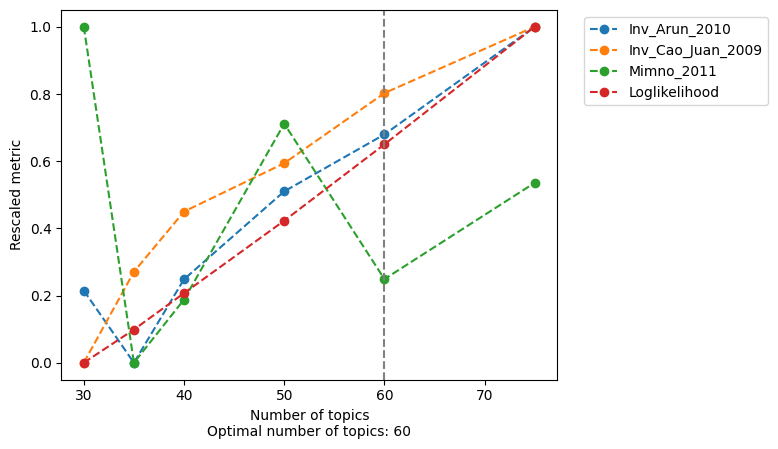

2025-10-27 15:37:32 - INFO - maxp pruned
2025-10-27 15:37:32 - INFO - cmap pruned
2025-10-27 15:37:32 - INFO - kern dropped
2025-10-27 15:37:32 - INFO - post pruned
2025-10-27 15:37:32 - INFO - FFTM dropped
2025-10-27 15:37:32 - INFO - GPOS pruned
2025-10-27 15:37:32 - INFO - GSUB pruned
2025-10-27 15:37:32 - INFO - glyf pruned
2025-10-27 15:37:32 - INFO - Added gid0 to subset
2025-10-27 15:37:32 - INFO - Added first four glyphs to subset
2025-10-27 15:37:32 - INFO - Closing glyph list over 'GSUB': 46 glyphs before
2025-10-27 15:37:32 - INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'I', 'J', 'L', 'M', 'N', 'O', 'R', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'zero']
2025-10-27 15:37:32 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 36, 38, 44, 45, 47, 48, 49

In [15]:
from pycisTopic.lda_models import evaluate_models
model=evaluate_models(models,
                     select_model=60, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'model_selection.pdf')

In [ ]:
obj.add_LDA_model(model)
with open(outDir + 'MiniAtlas_H3K27me3_snATAC_whole.union.peaks_240601_cisTopicObject.subset.pkl', 'wb') as f:
    pickle.dump(obj, f)

2025-10-27 17:50:05 - INFO - Running UMAP
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/mnt/tscc2/y2xie/scripts/git/pycisTopic/src/pycisTopic/clust_vis.py:519: FutureWarning: The provided callable <function mean at 0x7fd6502f11c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  label_pos = label_pd.groupby(var).agg(
/mnt/tscc2/y2xie/scripts/git/pycisTopic/src/pycisTopic/clust_vis.py:519: FutureWarning: The provided callable <function mean at 0x7fd6502f11c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  label_pos = label_pd.groupby(var).agg(
/mnt/tscc2/y2xie/scripts/git/pycisTopic/src/pycisTopic

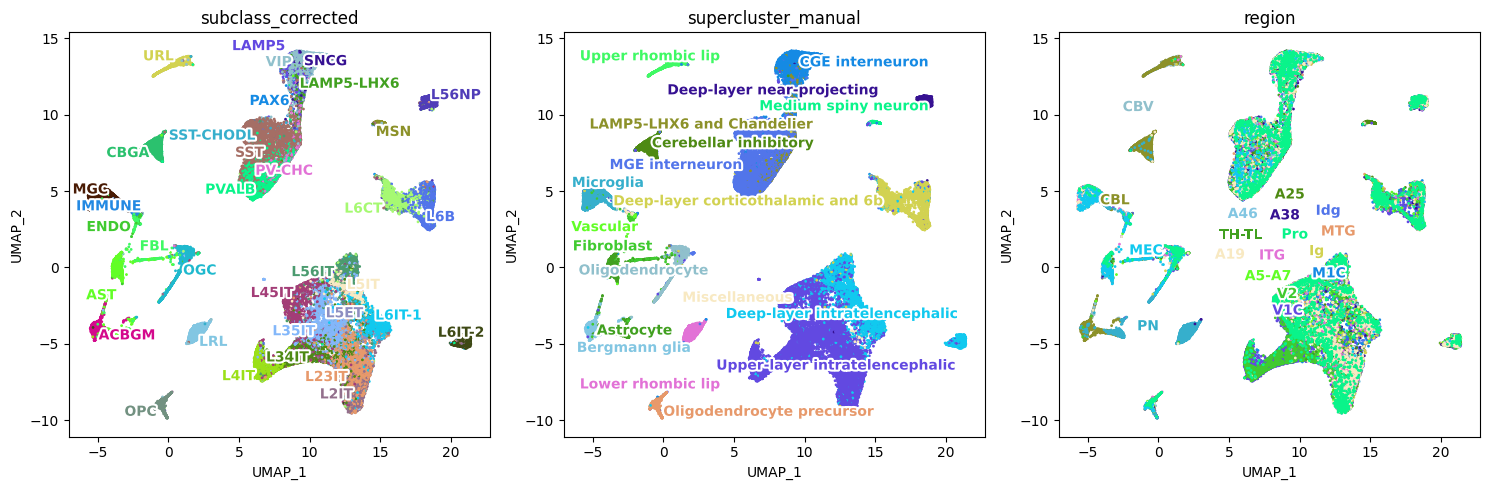

In [3]:
run_umap(obj, target = 'cell', scale=True)
plot_metadata(obj,
              reduction_name='UMAP',
              variables=['subclass_corrected', 'supercluster_manual', 'region'], # Labels from RNA and new clusters
              target='cell', num_columns=3,
              text_size=10,
              dot_size=1,
              figsize=(15,5))

In [4]:
region_bin_topics_otsu = binarize_topics(
    obj, method='otsu',
    plot=False, num_columns=5
)

In [5]:
region_bin_topics_top_3k = binarize_topics(
    obj, method='ntop', ntop = 3_000,
    plot=False, num_columns=5
)

/mnt/tscc2/y2xie/scripts/git/pycisTopic/src/pycisTopic/topic_binarization.py:152: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  thr = float(data.iloc[ntop,])


In [6]:
binarized_cell_topic = binarize_topics(
    obj,
    target='cell',
    method='li',
    plot=False,
    num_columns=5, nbins=100)

In [7]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
topic_annot = topic_annotation(
    obj,
    annot_var='subclass_corrected',
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr = 0.2
)

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


In [14]:
out_dir = "scplus_me3_pipeline/"
os.makedirs(os.path.join(out_dir, "region_set"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_set", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_set", "Topics_top_3k"), exist_ok = True)

from pycisTopic.utils import region_names_to_coordinates
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_set", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [15]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_set", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )